In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Un peu de notions en statistiques
"""

import scipy
import scipy.stats as stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import timeit

def average_std(vals,axis=0):
    """
    Retourne la moyenne et l'écart-type réduit sous forme de tuple selon l'axe indiqué
    """
    return (np.average(vals,axis=axis),np.std(vals,ddof=1,axis=axis))

def print_average_std(values_average,values_std):
    """
    Affichage des moyennes et écart-type
    """
    print("Moyenne")
    print(values_average.shape)
    print(values_average)
    print("Écart-type")
    print(values_std.shape)
    print(values_std)    


# Programme principal
if __name__ == "__main__":
    pass

In [2]:
#############
###Question 1
#############
#nombre de séries
n = 100
#nombre de tirages par série
p = 100000
#valeur moyenne et écart-type des deux gaussiennes
x1=5
ux1 = 0.5
x2=3
ux2=2
#seed pour le générateur de nombres aléatoires
seed = 666
#série pour laquelle on effectue les tracés
indix_plot = 0
#tirages aléatoires des deux variables
x_1 = stats.norm.rvs(loc=x1,scale=ux1,random_state=seed,size=(n,p))
x_2 = stats.norm.rvs(loc=x2,scale=ux2,random_state=seed,size=(n,p))
#############
###Question 2
#############
#Mise en commun des deux variables dans un unique tableau
xs = np.stack((x_1,x_2),axis=0)
print(xs.shape)
#############
###Question 3
#############
#Calcul des moyennes et de l'écart-type
#np.average(vals,axis=axis)
#np.std(vals,ddof=1,axis=axis)
values_average,values_std = average_std(xs,axis=-1)

#print_average_std(values_average,values_std)

    
    

(2, 100, 100000)


Produit
(100, 100000)


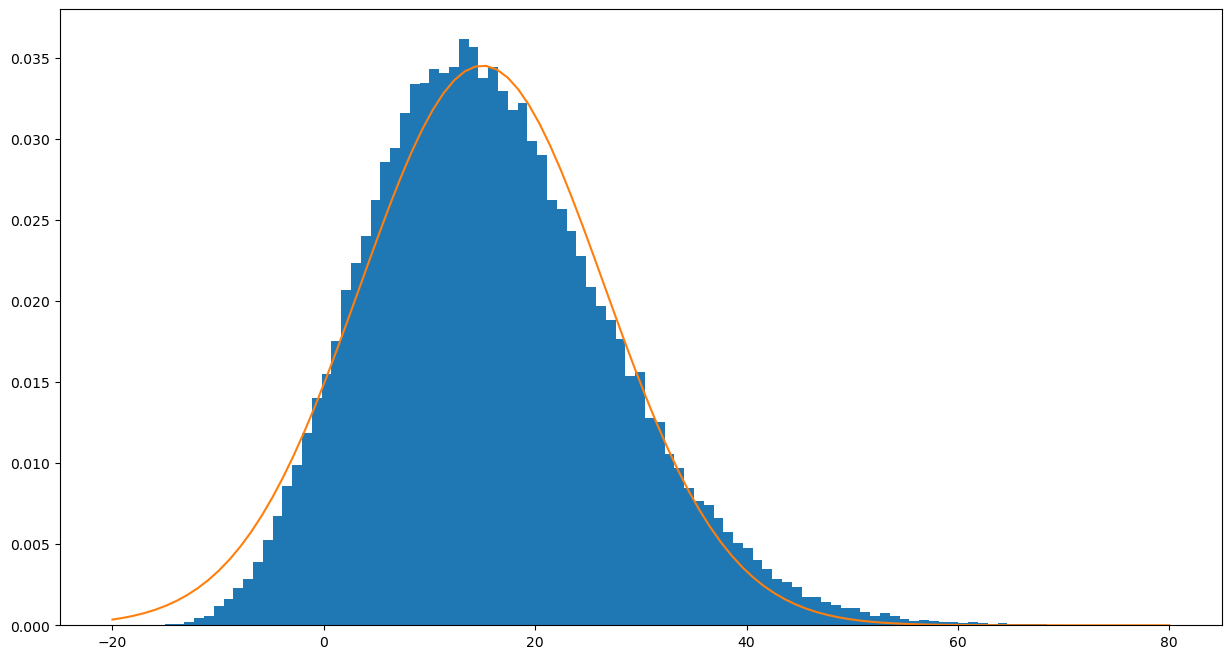

In [3]:
#############
###Question 4
#############
#calcul pour le produit
prod = xs[0,:]*xs[1,:]
values_average,values_std = average_std(prod,axis=-1)
#print_average_std(values_average,values_std)

print("Produit")
print(prod.shape)


#############
###Question 5
#############
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(1, 1, hspace=0.3)
ax1 = fig.add_subplot(gs[0, 0])
ax1.hist(prod[indix_plot,:],bins=101,density=True)
zs = np.linspace(-20,80,100)
ax1.plot(zs,stats.norm.pdf(zs,loc=15,scale = values_std[indix_plot] ))

plt.savefig('prodgauss.svg')
plt.show()

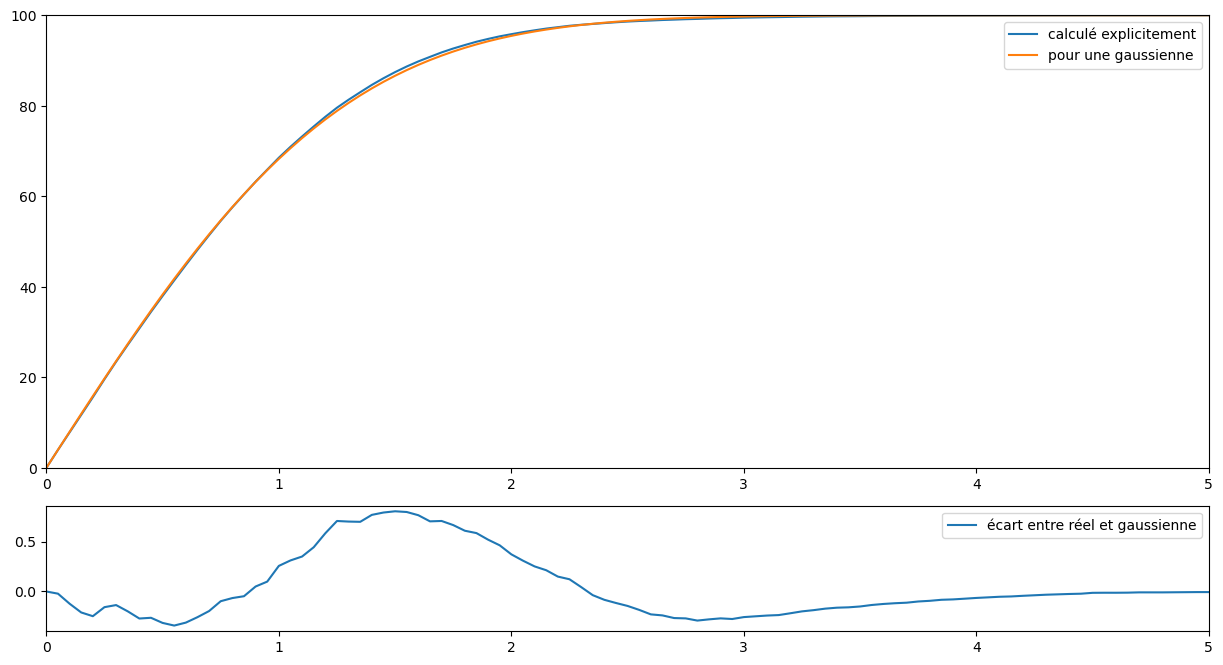

In [4]:
#############
###Question 6
#############

def IntervalleConfiance(x,data,moy):
    """
    Estimer l'intervalle de confiance associé à l'intervalle centré sur la valeur moyenne moy et de largeur x
    """
    count = ((moy-x < data) & (data < moy+x)).sum()/data.size*100.
    return count
#vectorisation de la fonction, on spécifie que la vectorisation doit avoir lieu uniquement sur le premier argument et pas les deux suivants.
#On aura donc l'équivalent d'une boucle for sur le premier argument, la vitesse en plus !
vectorized_function = np.vectorize(IntervalleConfiance,excluded=[1,2])

fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(4, 1, hspace=0.3)
ax1 = fig.add_subplot(gs[0:3, 0])
ks = np.linspace(0,5,101)

#Tracé de l'intervalle de confiance en fonction de k
ax1.plot(ks,vectorized_function(ks*values_std[indix_plot],prod[indix_plot,:],values_average[indix_plot]),label='calculé explicitement')
#calcul de la différence des cdf entre les deux valeurs au bord de l'intervalle
inter_confiance_gaussienne = 100 * (stats.norm.cdf(values_average[indix_plot]+ks*values_std[indix_plot],loc=values_average[indix_plot],scale = values_std[indix_plot]) - stats.norm.cdf(values_average[indix_plot]-ks*values_std[indix_plot],loc=values_average[indix_plot],scale = values_std[indix_plot]))



ax1.plot(ks,inter_confiance_gaussienne,label='pour une gaussienne')
ax1.legend()
ax1.set_ylim(0,100)
ax1.set_xlim(0,5)

ax2 = fig.add_subplot(gs[3, 0])



ax2.plot(ks,vectorized_function(ks*values_std[indix_plot],prod[indix_plot,:],values_average[indix_plot])-inter_confiance_gaussienne,label='écart entre réel et gaussienne')
ax2.set_xlim(0,5)
ax2.legend()
plt.savefig('intervalle-confiance.svg')
plt.show()


In [8]:
def IntervalleConfiance_series(ks,data,moy,std,i):
    """
    Estimer l'intervalle de confiance associé à l'intervalle centré sur la valeur moyenne moy et de largeur x
    """
    count = ((moy[i]-ks*std[i] < data[i,:]) & (data[i,:] < moy[i]+ks*std[i])).sum()/data[i,:].size*100.
    return count

#vectorisation de la nouvelle fonction
vectorized_function_variability = np.vectorize(IntervalleConfiance_series,excluded=[1,2,3])
#On doit faire des reshape pour qu'il y ait bien la double boucle sur k et sur la série qui soit effectuable
ks = ks.reshape((101,1))
indices = np.arange(100)
indices = indices.reshape(1,100)

#calcul des intervalles de confiance
start_timer = timeit.default_timer() 
inters = vectorized_function_variability(ks,prod,values_average,values_std,indices)

#On moyenne sur les 100 séries
moy_inter = np.average(inters,axis=-1)

In [13]:
def code_to_test():
    return vectorized_function_variability(ks,prod,values_average,values_std,indices)
print(timeit.timeit(code_to_test,number=10))

22.839088758002617


In [ ]:
fig = plt.figure(figsize=(15, 8))
gs = fig.add_gridspec(4, 1, hspace=0.3)
ax1 = fig.add_subplot(gs[0:3, 0])

ax1.plot(ks,moy_inter,label='pour une gaussienne')
ax1.set_ylim(0,100)
ax1.set_xlim(0,5)

ax2 = fig.add_subplot(gs[3, 0])

ax2.plot(ks,inters-moy_inter.reshape(101,1),alpha = 0.3)
ax2.set_xlim(0,5)

plt.savefig('intervalle-confiance_full.svg')
plt.show()


In [14]:
def slow_function(n,p,data,moy,std):
    """
    Une fonction extrêmement lente non vectorisée pour faire la même chose qu'à la question 8
    n : nombre de séries
    p : nombre de tirage par série
    data :  données brutes
    moy : moyennes de chaque série
    std : écart-type de chaque série
    """
    slow_results = np.zeros((n,101))
    for serie in range(n):
        for kindix,k in enumerate(np.linspace(0,5,101)):
            count = 0
            for tirage in range(p):
                if data[serie,tirage] < moy[serie]+k*std[serie] and data[serie,tirage] > moy[serie]-k*std[serie]:
                    count += 1 
            slow_results[serie,kindix] = count/p*100.
    return slow_results

start_time = timeit.default_timer()
slow_function(n,p,prod,values_average,values_std)
print(timeit.default_timer() - start_time)

840.5907254640042


# Code complet

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Un peu de notions en statistiques
"""

import scipy
import scipy.stats as stats
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import timeit

def average_std(vals,axis=0):
    """
    Retourne la moyenne et l'écart-type réduit sous forme de tuple selon l'axe indiqué
    """
    return (np.average(vals,axis=axis),np.std(vals,ddof=1,axis=axis))

def print_average_std(values_average,values_std):
    """
    Affichage des moyennes et écart-type
    """
    print("Moyenne")
    print(values_average.shape)
    print(values_average)
    print("Écart-type")
    print(values_std.shape)
    print(values_std)

def IntervalleConfiance(x,data,moy):
    """
    Estimer l'intervalle de confiance associé à l'intervalle centré sur la valeur moyenne moy et de largeur x
    """
    count = ((moy-x < data) & (data < moy+x)).sum()/data.size*100.
    return count

def IntervalleConfiance_series(ks,data,moy,std,i):
    """
    Estimer l'intervalle de confiance associé à l'intervalle centré sur la valeur moyenne moy et de largeur x
    """
    count = ((moy[i]-ks*std[i] < data[i,:]) & (data[i,:] < moy[i]+ks*std[i])).sum()/data[i,:].size*100.
    return count


# Programme principal
if __name__ == "__main__":
    #nombre de séries
    n = 100
    #nombre de tirages par série
    p = 100000
    #valeur moyenne et écart-type des deux gaussiennes
    x1=5
    ux1 = 0.5
    x2=3
    ux2=2
    #seed pour le générateur de nombres aléatoires
    seed = 666
    #série pour laquelle on effectue les tracés
    indix_plot = 0
    #tirages aléatoires des deux variables
    x_1 = stats.norm.rvs(loc=x1,scale=ux1,random_state=seed,size=(n,p))
    x_2 = stats.norm.rvs(loc=x2,scale=ux2,random_state=seed,size=(n,p))
    #Mise en commun des deux variables dans un unique tableau
    xs = np.stack((x_1,x_2),axis=0)
    print(xs.shape)
    #Calcul des moyennes et de l'écart-type
    values_average,values_std = average_std(xs,axis=-1)
    #print_average_std(values_average,values_std)

    #calcul pour le produit
    prod = xs[0,:]*xs[1,:]
    values_average,values_std = average_std(prod,axis=-1)
    #print_average_std(values_average,values_std)

    print("Produit")
    print(prod.shape)

    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(1, 1, hspace=0.3)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.hist(prod[indix_plot,:],bins=101,density=True)
    zs = np.linspace(-20,80,100)
    ax1.plot(zs,stats.norm.pdf(zs,loc=15,scale = values_std[indix_plot] ))

    plt.savefig('prodgauss.svg')
    plt.show()




    #vectorisation de la fonction, on spécifie que la vectorisation doit avoir lieu uniquement sur le premier argument et pas les deux suivants.
    #On aura donc l'équivalent d'une boucle for sur le premier argument, la vitesse en plus !
    vectorized_function = np.vectorize(IntervalleConfiance,excluded=[1,2])

    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(4, 1, hspace=0.3)
    ax1 = fig.add_subplot(gs[0:3, 0])
    ks = np.linspace(0,5,101)

    #Tracé de l'intervalle de confiance en fonction de k
    ax1.plot(ks,vectorized_function(ks*values_std[indix_plot],prod[indix_plot,:],values_average[indix_plot]),label='calculé explicitement')
    #calcul de la différence des cdf entre les deux valeurs au bord de l'intervalle
    inter_confiance_gaussienne = 100 * (stats.norm.cdf(values_average[indix_plot]+ks*values_std[indix_plot],loc=values_average[indix_plot],scale = values_std[indix_plot]) - stats.norm.cdf(values_average[indix_plot]-ks*values_std[indix_plot],loc=values_average[indix_plot],scale = values_std[indix_plot]))



    ax1.plot(ks,inter_confiance_gaussienne,label='pour une gaussienne')
    ax1.legend()
    ax1.set_ylim(0,100)
    ax1.set_xlim(0,5)

    ax2 = fig.add_subplot(gs[3, 0])



    ax2.plot(ks,vectorized_function(ks*values_std[indix_plot],prod[indix_plot,:],values_average[indix_plot])-inter_confiance_gaussienne,label='écart entre réel et gaussienne')
    ax2.set_xlim(0,5)
    ax2.legend()
    plt.savefig('intervalle-confiance.svg')
    plt.show()




    #vectorisation de la nouvelle fonction
    vectorized_function_variability = np.vectorize(IntervalleConfiance_series,excluded=[1,2,3])
    #On doit faire des reshape pour qu'il y ait bien la double boucle sur k et sur la série qui soit effectuable
    ks = ks.reshape((101,1))
    indices = np.arange(100)
    indices = indices.reshape(1,100)

    #calcul des intervalles de confiance
    start_timer = timeit.default_timer()
    inters = vectorized_function_variability(ks,prod,values_average,values_std,indices)

    #On moyenne sur les 100 séries
    moy_inter = np.average(inters,axis=-1)

    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(4, 1, hspace=0.3)
    ax1 = fig.add_subplot(gs[0:3, 0])

    ax1.plot(ks,moy_inter,label='pour une gaussienne')
    ax1.set_ylim(0,100)
    ax1.set_xlim(0,5)

    ax2 = fig.add_subplot(gs[3, 0])

    ax2.plot(ks,inters-moy_inter.reshape(101,1),alpha = 0.3)
    ax2.set_xlim(0,5)

    plt.savefig('intervalle-confiance_full.svg')
    plt.show()
    
    
    def code_to_test():
        return vectorized_function_variability(ks,prod,values_average,values_std,indices)
    print(timeit.timeit(code_to_test,number=10))


    def slow_function(n,p,data,moy,std):
        """
        Une fonction extrêmement lente non vectorisée pour faire la même chose qu'à la question 8
        n : nombre de séries
        p : nombre de tirage par série
        data :  données brutes
        moy : moyennes de chaque série
        std : écart-type de chaque série
        """
        slow_results = np.zeros((n,101))
        for serie in range(n):
            for kindix,k in enumerate(np.linspace(0,5,101)):
                count = 0
                for tirage in range(p):
                    if data[serie,tirage] < moy[serie]+k*std[serie] and data[serie,tirage] > moy[serie]-k*std[serie]:
                        count += 1
                slow_results[serie,kindix] = count/p*100.
        return slow_results

    start_time = timeit.default_timer()
    slow_function(n,p,prod,values_average,values_std)
    print(timeit.default_timer() - start_time)

